# XGBoost Model

### DecisionTree

In [59]:
import numpy as np

class DecisionTree:
    """ 
    A class representing a decision tree model used in gradient boosting.
    Attributes:
        max_depth (int): Maximum depth of the tree.
        min_samplessplit (int): Minimum number of samples required to split a node.
        tree (dict or float): The root of the tree, represented as a dictionary or a leaf value.
    """
    def __init__(self, max_depth=3, min_samplessplit=2):
        """ 
        Initializes the DecisionTree with maximum depth and minimum samples required to split.
        @params:
            max_depth (int): The maximum depth of the tree. Default is 3.
            min_samplessplit (int): Minimum samples required to split a node. Default is 2.
        """
        self.max_depth = max_depth
        self.min_samplessplit = min_samplessplit
        self.tree = None

    def train(self, X, y, grad, hess):
        """ 
        Trains the decision tree using the given data, gradients, and hessians.
        @params:
            X (numpy.ndarray): A 2D array of shape (n_samples, n_features) with training data.
            y (numpy.ndarray): A 1D array of shape (n_samples,) with target values.
            grad (numpy.ndarray): A 1D array of gradients for each sample.
            hess (numpy.ndarray): A 1D array of hessians for each sample.
        """
        self.tree = self.build_tree(X, y, grad, hess)

    def split(self, X, y, grad, hess):
        """ 
        Finds the best split for the data to maximize the gain.
        @params:
            X (numpy.ndarray): A 2D array of shape (n_samples, n_features) with training data.
            y (numpy.ndarray): A 1D array of shape (n_samples,) with target values.
            grad (numpy.ndarray): A 1D array of gradients for each sample.
            hess (numpy.ndarray): A 1D array of hessians for each sample.
        @return:
            tuple: The best feature index and threshold for the split.
        """
        best_gain = -np.inf
        best_split = None
        # Iterate over all features to find the best split point
        for feature_index in range(X.shape[1]):
            # Sort feature values and compute threshold for splits
            sorted_index = np.argsort(X[:, feature_index])
            X_sorted, grad_sorted, hess_sorted = X[sorted_index, feature_index], grad[sorted_index], hess[sorted_index]
            # Initialize left and right sum of gradients and Hessians
            G_L, H_L = 0, 0  
            G_R, H_R = np.sum(grad_sorted), np.sum(hess_sorted)

            # Iterate over feature values to find the best split point
            for i in range(1, len(X_sorted)):
                G_L += grad_sorted[i - 1]
                H_L += hess_sorted[i - 1]
                G_R -= grad_sorted[i - 1]
                H_R -= hess_sorted[i - 1]

                # Check if the split meets the minimum sample requirement
                if i < self.min_samplessplit or len(X_sorted) - i < self.min_samplessplit:
                    continue

                # Calculate gain for this split using a separate function
                gain = self.gain(G_L, H_L, G_R, H_R)
                
                # Update the best gain and split if the current gain is higher
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_index, (X_sorted[i - 1] + X_sorted[i]) / 2)
                    
        return best_split

    def gain(self, G_L, H_L, G_R, H_R):
        """ 
        Calculates the gain of a split using left and right gradient and Hessian sums.
        @params:
            G_L (float): Sum of gradients for the left split.
            H_L (float): Sum of Hessians for the left split.
            G_R (float): Sum of gradients for the right split.
            H_R (float): Sum of Hessians for the right split.
        @return:
            float: The calculated gain for the split.
        """
        # Gain formula using left and right gradient and Hessian sums
        gain = 0.5 * ((G_L ** 2) / (H_L + 1e-10) + (G_R ** 2) / (H_R + 1e-10) - ((G_L + G_R) ** 2) / (H_L + H_R + 1e-10))
        return gain

    def build_tree(self, X, y, grad, hess, depth=0):
        """ 
        Recursively builds the decision tree based on the provided data.
        @params:
            X (numpy.ndarray): A 2D array of shape (n_samples, n_features) with training data.
            y (numpy.ndarray): A 1D array of target values.
            grad (numpy.ndarray): A 1D array of gradients for each sample.
            hess (numpy.ndarray): A 1D array of hessians for each sample.
            depth (int): The current depth of the tree.
        @return:
            dict or float: A dictionary representing the subtree or a leaf value.
        """
        if depth == self.max_depth or len(y) < self.min_samplessplit:
            # Return leaf value if maximum depth is reached or samples are insufficient
            leaf_value = -np.sum(grad) / (np.sum(hess) + 1e-10)
            return leaf_value

        best_split = self.split(X, y, grad, hess)
        if not best_split:
            # Return leaf value if no valid split is found
            return -np.sum(grad) / (np.sum(hess) + 1e-10)

        feature_index, threshold = best_split
        left_mask = X[:, feature_index] < threshold
        right_mask = ~left_mask

        # Recursively build left and right subtrees
        left_subtree = self.build_tree(X[left_mask], y[left_mask], grad[left_mask], hess[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], grad[right_mask], hess[right_mask], depth + 1)
        return {"feature_index": feature_index, "threshold": threshold, "left": left_subtree, "right": right_subtree}

    def predict_single(self, x, tree):
        """ 
        Predicts the value for a single sample using the decision tree.
        @params:
            x (numpy.ndarray): A 1D array of feature values for a single sample.
            tree (dict or float): The decision tree or leaf value to predict with.
        @return:
            float: The predicted value for the sample.
        """
        if not isinstance(tree, dict):
            # Return the leaf value if the node is a leaf
            return tree

        feature_index = tree["feature_index"]
        threshold = tree["threshold"]
        # Traverse left or right subtree based on the feature value
        if x[feature_index] < threshold:
            return self.predict_single(x, tree["left"])
        else:
            return self.predict_single(x, tree["right"])

    def predict(self, X):
        """ 
        Predicts the values for multiple samples using the decision tree.
        @params:
            X (numpy.ndarray): A 2D array of shape (n_samples, n_features) with input data.
        @return:
            numpy.ndarray: A 1D array of predicted values for each sample.
        """
        return np.array([self.predict_single(x, self.tree) for x in X])

    def print_tree(self, tree=None, depth=0):
        """ 
        Prints the structure of the decision tree.
        @params:
            tree (dict or float, optional): The tree to print. If None, use the root tree.
            depth (int): The current depth in the tree for formatting purposes.
        """
        if tree is None:
            tree = self.tree
        # Indentation of each tree when printing
        tabcnt = "\t" * depth  
        # If the node is a leaf
        if not isinstance(tree, dict):  
            print(f"{tabcnt}{tree:.4f}")
        else:  
            feature_index = tree["feature_index"]
            threshold = tree["threshold"]
            # Print the splitting condition
            print(f"{tabcnt}{depth}:[f{feature_index}<{threshold:.8f}] yes={depth + 1},no={depth + 2},missing={depth + 2}")
            print(f"{tabcnt}\tyes->")
            self.print_tree(tree["left"], depth + 1)
            print(f"{tabcnt}\tno->")
            self.print_tree(tree["right"], depth + 1)

### XGBoost

In [60]:
class XGBoost:
    """ 
    XGBoost for binary classification.
    Attributes:
        num_trees (int): Number of boosting rounds (trees).
        max_depth (int): Maximum depth of each decision tree.
        min_samplessplit (int): Minimum number of samples required to split an internal node.
        learning_rate (float): Step size shrinkage used in update to prevent overfitting.
        trees (list): List of trained decision tree models.
    """
    def __init__(self, num_trees=10, max_depth=3, min_samplessplit=2, learning_rate=0.1):
        """ 
        Initializes the XGBoost model with the specified parameters.
        @params:
            num_trees (int): Number of trees to fit. Default is 10.
            max_depth (int): Maximum depth of each tree. Default is 3.
            min_samplessplit (int): Minimum samples required to split a node. Default is 2.
            learning_rate (float): Learning rate for the model. Default is 0.1.
        """
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.min_samplessplit = min_samplessplit
        self.learning_rate = learning_rate
        self.trees = []

    def train(self, X, y, detailed=False):
        """ 
        Trains the XGBoost model using the training data.
        @params:
            X (numpy.ndarray): A 2D array of shape (n_samples, n_features) with the training data.
            y (numpy.ndarray): A 1D array of shape (n_samples,) with the target labels.
            detailed (boolean): Whether to print the current tree when interating. Default is true.
        """
        # Initialize predictions with zeros
        y_pred = np.zeros_like(y, dtype=float)

        # Train each tree iteratively
        for i in range(self.num_trees):
            # Compute gradients and hessians
            grad, hess = self.gradient(y, y_pred)
            
            # Initialize and train a new decision tree
            tree = DecisionTree(max_depth=self.max_depth, min_samplessplit=self.min_samplessplit)
            tree.train(X, y, grad, hess)
            
            # Make predictions using the trained tree
            predictions = tree.predict(X)
            
            # Update predictions with the learning rate
            y_pred += self.learning_rate * predictions
            self.trees.append(tree)

            if detailed:
                # Print the structure of the current tree
                print(f"Tree {i + 1}:")
                tree.print_tree()
                # Calculate and print the cross-entropy loss using sigmoid
                loss = self.cross_entropy_loss(y, 1 / (1 + np.exp(-y_pred)))
                print(f"Loss after Tree {i + 1}: {loss}")
                print("\n")

    def gradient(self, y, y_pred):
        """ 
        Computes the gradients and hessians for the loss function.
        @params:
            y (numpy.ndarray): A 1D array of target labels.
            y_pred (numpy.ndarray): A 1D array of current predictions.
        @return:
            tuple: A tuple containing:
                - grad (numpy.ndarray): A 1D array of gradients for each sample.
                - hess (numpy.ndarray): A 1D array of hessians for each sample.
        """
        # Compute the first derivative (gradient)
        grad = y_pred - y
        
        # For the squared error loss, the second derivative (hessian) is constant and equal to 1
        hess = np.ones_like(y)
        return grad, hess

    def cross_entropy_loss(self, y, y_pred):
        """ 
        Computes the cross-entropy loss between true and predicted labels.
        @params:
            y (numpy.ndarray): A 1D array of target labels.
            y_pred (numpy.ndarray): A 1D array of predicted probabilities.
        @return:
            float: The mean cross-entropy loss.
        """
        # Clip predicted probabilities to avoid log(0)
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return loss

    def predict(self, X):
        """ 
        Outputs predicted labels for the input data using the trained trees.
        @params:
            X (numpy.ndarray): A 2D array of shape (n_samples, n_features) with the input data.
        @return:
            numpy.ndarray: A 1D array of predicted values for each sample.
        """
        # Initialize predictions with zeros
        y_pred = np.zeros(X.shape[0])

        # Aggregate predictions from each tree
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


# Check Model

In [80]:
import numpy as np
import pytest

# Sets random seed for reproducibility
np.random.seed(0)

# Synthetic dataset 1: Linearly separable data
X_linear = np.array([
    [float(i), float(2 * i + 1)] for i in range(10)
])
y_linear = np.array([0 if x[0] < 5 else 1 for x in X_linear])
y_pred_linear = np.zeros_like(y_linear, dtype=float)

# Synthetic dataset 2: Non-linearly separable data
X_nonlinear = np.random.rand(20, 2) * 10  # Random points in a 10x10 grid
y_nonlinear = np.array([1 if x[0]**2 + x[1]**2 < 50 else 0 for x in X_nonlinear])
y_pred_nonlinear = np.zeros_like(y_nonlinear, dtype=float)

test_gain_cases = [
    # Format: (G_L, H_L, G_R, H_R, expected_gain)
    (10.0, 5.0, 20.0, 10.0, -2.000000165480742e-10),
    (5.0, 2.0, 15.0, 8.0, 0.3124999997117186),
    (0.0, 1.0, 0.0, 1.0, 0.0),
    (10.0, 0.1, 10.0, 0.1, -4.999999418942025e-07)
]

# Additional edge cases
# Minimal dataset
X_minimal = np.array([[1.0, 2.0]])
y_minimal = np.array([1])

# Zero gradient and Hessian
X_zero_grad = np.array([[1.0, 1.0], [2.0, 2.0]])
y_zero_grad = np.array([0, 1])

# Identical features
X_identical = np.array([[1.0, 1.0], [1.0, 1.0], [1.0, 1.0]])
y_identical = np.array([0, 0, 1])

# Creates a simple parameter dictionary
params = {
    'num_trees': 4,
    'max_depth': 3,
    'min_samplessplit': 2,
    'learning_rate': 0.3
}


# Test model with a minimal dataset (1 sample).
def test_minimal_dataset():
    """
    Validates the DecisionTree model's behavior with the smallest possible dataset (one sample).
    Purpose: Ensure the model can train and predict with minimal input data.
    """
    tree = DecisionTree(max_depth=1, min_samplessplit=1)
    tree.train(X_minimal, y_minimal, grad=np.zeros_like(y_minimal)-y_minimal, hess=np.ones_like(y_minimal))
    predictions = tree.predict(X_minimal)
    assert predictions.shape == y_minimal.shape
    assert predictions[0] == pytest.approx(1, .001)
    print(f"Minimal dataset test passed with predictions {predictions[0]:.2f} ")


# Test model with zero gradient and Hessian values.
def test_zero_gradient_hessian():
    """
    Checks the DecisionTree's response to a dataset with zero gradients and Hessians.
    Purpose: Verify that the model handles edge cases where no learning signal exists.
    """
    tree = DecisionTree(max_depth=2, min_samplessplit=1)
    grad = np.zeros_like(y_zero_grad)
    hess = np.zeros_like(y_zero_grad)
    tree.train(X_zero_grad, y_zero_grad, grad=grad, hess=hess)
    predictions = tree.predict(X_zero_grad)
    print(f"Predictions with zero gradient/hessian: {predictions}")
    assert predictions.shape == y_zero_grad.shape
    print("Zero gradient and Hessian test passed.")


# Test model on dataset with identical feature values.
def test_identical_features():
    """
    Tests the DecisionTree on a dataset where all feature values are identical.
    Purpose: Evaluate the model's ability to handle cases where no meaningful split is possible.
    """
    tree = DecisionTree(max_depth=2, min_samplessplit=1)
    tree.train(X_identical, y_identical, grad=np.zeros_like(y_identical)-y_identical, hess=np.ones_like(y_identical))
    predictions = tree.predict(X_identical)
    print(f"Predictions with identical features: {predictions}")
    assert np.all(predictions == predictions[0]), "Model failed on identical features dataset."
    print("Identical features test passed.")


# Test gain calculation for various cases.
def test_gain():
    """
    Evaluates the correctness of the gain function used in the tree-splitting logic.
    Purpose: Ensure gain calculations match expected values for test cases.
    """
    tree = DecisionTree(max_depth=2, min_samplessplit=1)
    # Test each case
    for i, (G_L, H_L, G_R, H_R, expected_gain) in enumerate(test_gain_cases):
        gain = tree.gain(G_L, H_L, G_R, H_R)
        assert abs(gain - expected_gain) < 1e-5, f"Test case {i+1} failed: expected {expected_gain}, got {gain}"
    print("Gain computation test passed.")


# Test the best split function in the DecisionTree class.
def test_split():
    """
    Assesses the DecisionTree's ability to identify the optimal split point for a dataset.
    Purpose: Verify that the split logic works correctly for both linear and non-linear datasets.
    """
    tree = DecisionTree(max_depth=2, min_samplessplit=1)
    split_feature1, split_value1 = tree.split(X_linear, y_linear, grad=y_pred_linear-y_linear, hess=np.ones_like(y_linear))
    split_feature2, split_value2 = tree.split(X_nonlinear, y_nonlinear, grad=np.ones_like(y_nonlinear), hess=np.ones_like(y_nonlinear))
    assert split_feature1 == 0
    assert split_feature2 == 0
    assert split_value1 == pytest.approx(4.5, .001)
    assert split_value2 == pytest.approx(0.195, .001)
    print("Split test passed.")


# Test DecisionTree on linearly separable data.
def test_decision_tree_with_linear_data():
    """
    Validates the DecisionTree's performance on a linearly separable dataset.
    Purpose: Ensure the model achieves 100% accuracy on simple linearly separable data.
    """
    tree = DecisionTree(max_depth=3, min_samplessplit=2)
    tree.train(X_linear, y_linear, grad=y_pred_linear-y_linear, hess=np.ones_like(y_linear))
    predictions = tree.predict(X_linear)
    assert predictions.shape == y_linear.shape
    accuracy = np.mean((predictions > 0.5) == y_linear)
    assert accuracy == 1.0, f"Expected accuracy 1.0, got {accuracy}"
    print(f"DecisionTree accuracy on linear dataset: {accuracy:.2f}")


# Test DecisionTree on non-linearly separable data.
def test_decision_tree_with_nonlinear_data():
    """
    Tests the DecisionTree's performance on a non-linearly separable dataset.
    Purpose: Check how well the model handles more complex decision boundaries.
    """
    tree = DecisionTree(max_depth=3, min_samplessplit=2)
    tree.train(X_nonlinear, y_nonlinear, grad=y_pred_nonlinear-y_nonlinear, hess=np.ones_like(y_nonlinear))
    predictions = tree.predict(X_nonlinear)
    assert predictions.shape == y_nonlinear.shape
    accuracy = np.mean((predictions > 0.5) == y_nonlinear)
    print(f"DecisionTree accuracy on non-linear dataset: {accuracy:.2f}")


# Test gradient and hessian computation in the XGBoost model.
def test_compute_gradients():
    """
    Validates gradient and Hessian computation in the XGBoost model for synthetic datasets.
    Purpose: Ensure that gradient calculations are consistent with expectations.
    """
    model = XGBoost(**params)
    gradients1, _ = model.gradient(y_linear, y_pred_linear)
    gradients2, _ = model.gradient(y_nonlinear, y_pred_nonlinear)
    assert gradients1 == pytest.approx(np.array([0., 0., 0., 0., 0., -1., -1., -1., -1., -1.]), .001)
    assert gradients2 == pytest.approx(np.array([0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., -1., 0., -1., 0., 0., -1., 0., 0.]), .001)
    print("Gradients computation test passed.")


# Test cross-entropy loss calculation in the XGBoost model.
def test_cross_entropy_loss():
    """
    Verifies the accuracy of cross-entropy loss calculation in XGBoost.
    Purpose: Ensure loss is computed correctly for different datasets.
    """
    model = XGBoost(**params)
    loss1 = model.cross_entropy_loss(y_linear, y_pred_linear)
    loss2 = model.cross_entropy_loss(y_nonlinear, y_pred_nonlinear)
    assert loss1 == pytest.approx(11.513, .001)
    assert loss2 == pytest.approx(4.605, .001)
    print("Cross entropy loss test passed.")


# Test XGBoost on linearly separable data.
def test_xgboost_with_linear_data():
    """
    Tests the XGBoost model's ability to learn from a linearly separable dataset.
    Purpose: Validate that XGBoost achieves 100% accuracy on simple datasets.
    """
    model = XGBoost(**params)
    model.train(X_linear, y_linear, detailed=False)
    predictions = model.predict(X_linear)
    assert predictions.shape == y_linear.shape
    accuracy = np.mean((predictions > 0.5) == y_linear)
    assert accuracy == 1.0, f"Expected accuracy 1.0, got {accuracy}"
    print(f"XGBoost accuracy on linear dataset: {accuracy:.2f}")


# Test XGBoost on non-linearly separable data.
def test_xgboost_with_nonlinear_data():
    """
    Evaluates the performance of the XGBoost model on non-linearly separable data.
    Purpose: Measure the model's capability to adapt to complex decision boundaries.
    """
    model = XGBoost(**params)
    model.train(X_nonlinear, y_nonlinear, detailed=False)
    predictions = model.predict(X_nonlinear)
    assert predictions.shape == y_nonlinear.shape
    accuracy = np.mean((predictions > 0.5) == y_nonlinear)
    print(f"XGBoost accuracy on non-linear dataset: {accuracy:.2f}")


# Run tests with synthetic datasets
test_minimal_dataset()
test_zero_gradient_hessian()
test_identical_features()
test_gain()
test_split()
test_decision_tree_with_linear_data()
test_decision_tree_with_nonlinear_data()
test_compute_gradients()
test_cross_entropy_loss()
test_xgboost_with_linear_data()
test_xgboost_with_nonlinear_data()

print("All tests passed!")


Minimal dataset test passed with predictions 1.00 
Predictions with zero gradient/hessian: [0. 0.]
Zero gradient and Hessian test passed.
Predictions with identical features: [0.33333333 0.33333333 0.33333333]
Identical features test passed.
Gain computation test passed.
Split test passed.
DecisionTree accuracy on linear dataset: 1.00
DecisionTree accuracy on non-linear dataset: 0.90
Gradients computation test passed.
Cross entropy loss test passed.
XGBoost accuracy on linear dataset: 1.00
XGBoost accuracy on non-linear dataset: 0.95
All tests passed!


# 1.Breast Cancer Diagnosis

## Implementing with OUR XGBoost

In [85]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset from a CSV file using numpy's genfromtxt
data = np.genfromtxt('dataset/breast+cancer+wisconsin+diagnostic/wdbc.data', delimiter=',', dtype=str)

# Extract features and convert them to float
X = data[:, 2:].astype(float)  # Features start from the 3rd column (index 2)
# Convert the labels to binary (Malignant -> 1, Benign -> 0)
y = np.where(data[:, 1] == 'M', 1, 0)

# Normalize the features using mean and standard deviation
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the XGBoost model we implemented earlier
model = XGBoost(num_trees=5, max_depth=5, learning_rate=0.3)

# Trains the XGBoost model on the training data.
model.train(X_train, y_train)

# Generates predictions on the test data.
predictions = model.predict(X_test)

# Convert predictions to binary labels (0 or 1) using a threshold of 0.5
predictions = np.where(predictions >= 0.5, 1, 0)

# Calculate the accuracy of the model
accuracy = np.mean(predictions == y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.956140350877193


### K-Fold Cross Validation

In [95]:
from sklearn.model_selection import KFold

# Define 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store accuracy for each fold
accuracy_scores = []

# Perform 5-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data into train and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize and train the XGBoost model on the training data
    model = XGBoost(num_trees=5, max_depth=5, learning_rate=0.3)
    model.train(X_train, y_train, detailed=False)
    
    # Generate predictions on the test data
    y_prob = model.predict(X_test)
    
    # Convert predictions to binary labels (0 or 1) using a threshold of 0.5
    predictions = np.where(y_prob >= 0.5, 1, 0)
    
    # Calculate accuracy for this fold
    accuracy = np.mean(predictions == y_test)
    accuracy_scores.append(accuracy)
    print(f'Fold {fold} Accuracy: {accuracy:.4f}')

# Calculate the average accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)

Fold 1 Accuracy: 0.9561
Fold 2 Accuracy: 0.9649
Fold 3 Accuracy: 0.9211
Fold 4 Accuracy: 0.9561
Fold 5 Accuracy: 0.9204


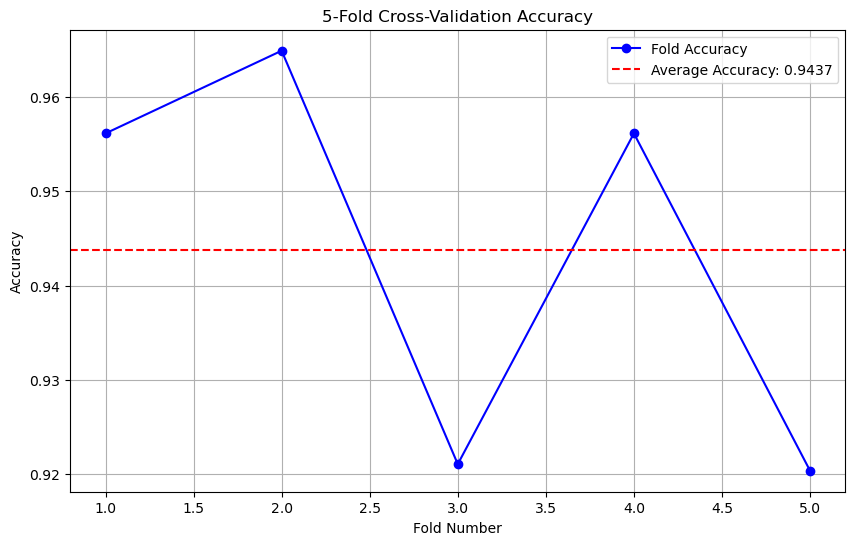

In [87]:
import matplotlib.pyplot as plt

# Plot the accuracy scores for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(mean_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {mean_accuracy:.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Implementing with imported XGBoost

In [91]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data from a CSV file
data = np.genfromtxt('wdbc.data', delimiter=',', dtype=str)

# Extract features and convert them to float for numerical operations
X = data[:, 2:].astype(float)  # Features start from the 3rd column (index 2)

# Convert labels from 'M' (Malignant) and 'B' (Benign) to binary (1 and 0)
y = np.where(data[:, 1] == 'M', 1, 0)

# Normalize the features by subtracting the mean and dividing by the standard deviation
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost model with log loss as the evaluation metric
model = xgb.XGBClassifier(n_estimators=5, max_depth=5, eval_metric='logloss')

# Fits the XGBoost model to the training data.
model.fit(X_train, y_train)

# Retrieve and print model parameters for reference
params = model.get_params()
print(params)
n_estimators = params['n_estimators']
max_depth = params['max_depth']
learning_rate = params['learning_rate']

print("Number of estimators:", n_estimators)
print("Max depth:", max_depth)
print("Learning rate:", learning_rate)

# Retrieve the trained booster (underlying model) from XGBoost
booster = model.get_booster()

# Iterate over each tree in the model and print its structure
for i, tree in enumerate(booster.get_dump()):
    print(f"Tree {i + 1} structure:\n{tree}\n")

# Make predictions on the test data
y_pred_s = model.predict(X_test)

# Compute and print the accuracy score
accuracy_s = accuracy_score(y_test, y_pred_s)
print("Model Accuracy:", accuracy_s)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 5, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Number of estimators: 5
Max depth: 5
Learning rate: None
Tree 1 structure:
0:[f27<0.42320466] yes=1,n

### K-Fold Cross Validation

In [92]:
from sklearn.model_selection import KFold

# Define 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store accuracy for each fold
accuracy_scores = []

# Perform 5-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data into train and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create an XGBoost model with log loss as the evaluation metric
    model = xgb.XGBClassifier(n_estimators=5, max_depth=5, eval_metric='logloss')
    
    # Fits the XGBoost model to the training data.
    model.fit(X_train, y_train)
    
    # Generate predictions
    predictions = model.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    print(f'Fold {fold} Accuracy: {accuracy:.4f}')

# Calculate the average accuracy across all folds
mean_accuracy_s = np.mean(accuracy_scores)

Fold 1 Accuracy: 0.9561
Fold 2 Accuracy: 0.9474
Fold 3 Accuracy: 0.9298
Fold 4 Accuracy: 0.9211
Fold 5 Accuracy: 0.9381


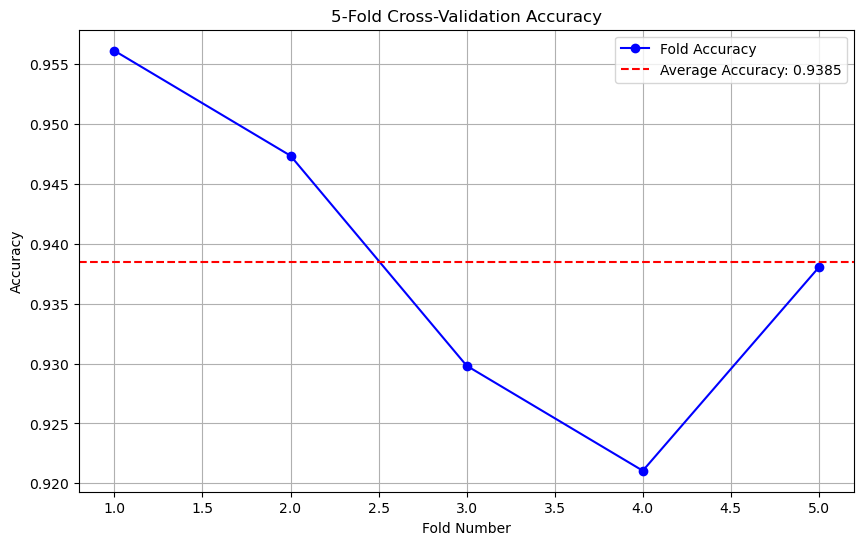

In [93]:
# Plot the accuracy scores for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(mean_accuracy_s, color='r', linestyle='--', label=f'Average Accuracy: {mean_accuracy_s:.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2.Customer Exited Prediction

## Implementing with OUR XGBoost

In [97]:
from sklearn.preprocessing import LabelEncoder
# Load the Customer dataset
data = pd.read_csv('dataset/Customer/Churn_Predictions.csv')
data = data.drop(['RowNumber','CustomerId','Surname'],axis=1)

# Create a sample dataframe with categorical data
Genderr = pd.DataFrame({'Gender': ['Male', 'Female']})
Geographyy = pd.DataFrame({'Geography': ['France', 'Germany','Spain']})  

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the categorical data
data['Gender'] = le.fit_transform(data['Gender'])
data['Geography'] = le.fit_transform(data['Geography'])

# Data pre-processing
X = data.drop('Exited', axis=1)
y = data['Exited']
X = X.values if isinstance(X, pd.DataFrame) else X
y = y.values if isinstance(y, pd.Series) else y

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the XGBoost model we implemented earlier and train it
model = XGBoost(num_trees=5, max_depth=5, learning_rate=0.3)
model.train(X_train, y_train)

# Generates predictions on the test data.
predictions = model.predict(X_test)

# Convert predictions to binary labels (0 or 1) using a threshold of 0.5
predictions = np.where(predictions >= 0.5, 1, 0)

# Calculate the accuracy of the model
accuracy = np.mean(predictions == y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.853


### K-Fold Cross Validation

In [98]:
from sklearn.model_selection import KFold

# Define 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store accuracy for each fold
accuracy_scores = []
# Perform 5-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data into train and test sets for this fold    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and train the XGBoost model on the training data
    model_x = XGBoost(num_trees=5, max_depth=5, learning_rate=0.3)
    model_x.train(X_train, y_train, detailed=False)
    
    # Generate predictions on the test data
    y_prob = model.predict(X_test)
    
    # Convert predictions to binary labels (0 or 1) using a threshold of 0.5
    predictions = np.where(y_prob >= 0.5, 1, 0)
    
    # Calculate accuracy for this fold
    accuracy = np.mean(predictions == y_test)
    accuracy_scores.append(accuracy)
    print(f'Fold {fold} Accuracy: {accuracy:.4f}')

# Calculate the average accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)

Fold 1 Accuracy: 0.8530
Fold 2 Accuracy: 0.8515
Fold 3 Accuracy: 0.8465
Fold 4 Accuracy: 0.8545
Fold 5 Accuracy: 0.8530


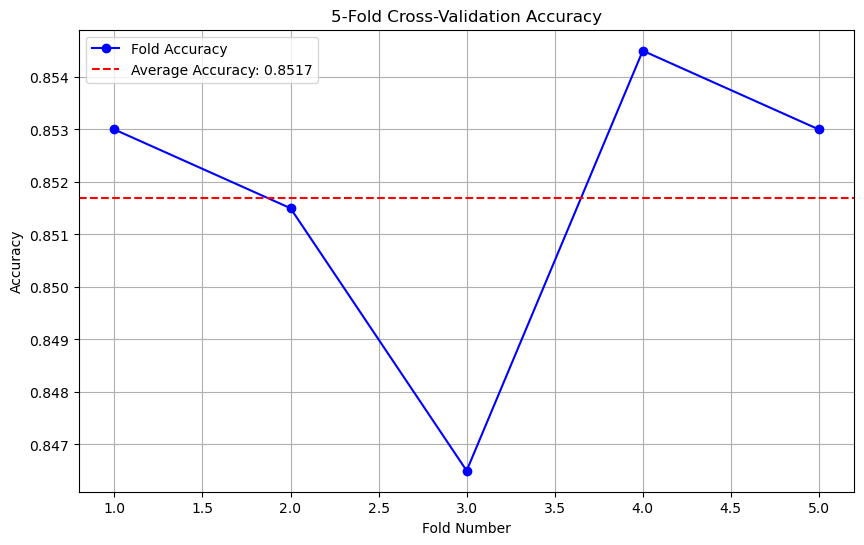

In [99]:
# Plot the accuracy scores for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(mean_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {mean_accuracy:.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Implementing with imported XGBoost

In [119]:
model = xgb.XGBClassifier(n_estimators=5, max_depth=5, eval_metric='logloss')
model.fit(X_train, y_train)
# Retrieve and print model parameters for reference
params = model.get_params()
print(params)
n_estimators = params['n_estimators']
max_depth = params['max_depth']
learning_rate = params['learning_rate']

print("Number of estimators:", n_estimators)
print("Max depth:", max_depth)
print("Learning rate:", learning_rate)

# Retrieve the trained booster (underlying model) from XGBoost
booster = model.get_booster()

# Iterate over each tree in the model and print its structure
for i, tree in enumerate(booster.get_dump()):
    print(f"Tree {i + 1} structure:\n{tree}\n")

# Make predictions on the test data
y_pred_s = model.predict(X_test)

# Compute and print the accuracy score
accuracy_s = accuracy_score(y_test, y_pred_s)
print("Model Accuracy:", accuracy_s)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 5, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Number of estimators: 5
Max depth: 5
Learning rate: None
Tree 1 structure:
0:[f4<1] yes=1,no=2,missin

### K-Fold Cross Validation

In [103]:
from sklearn.model_selection import KFold

# Define 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store accuracy for each fold
accuracy_scores = []

# Perform 5-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data into train and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create an XGBoost model with log loss as the evaluation metric
    model = xgb.XGBClassifier(n_estimators=5, max_depth=5, eval_metric='logloss')
    
    # Fits the XGBoost model to the training data.
    model.fit(X_train, y_train)
    
    # Generate predictions
    predictions = model.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    print(f'Fold {fold} Accuracy: {accuracy:.4f}')

# Calculate the average accuracy across all folds
mean_accuracy_s = np.mean(accuracy_scores)

Fold 1 Accuracy: 0.8610
Fold 2 Accuracy: 0.8615
Fold 3 Accuracy: 0.8495
Fold 4 Accuracy: 0.8635
Fold 5 Accuracy: 0.8530


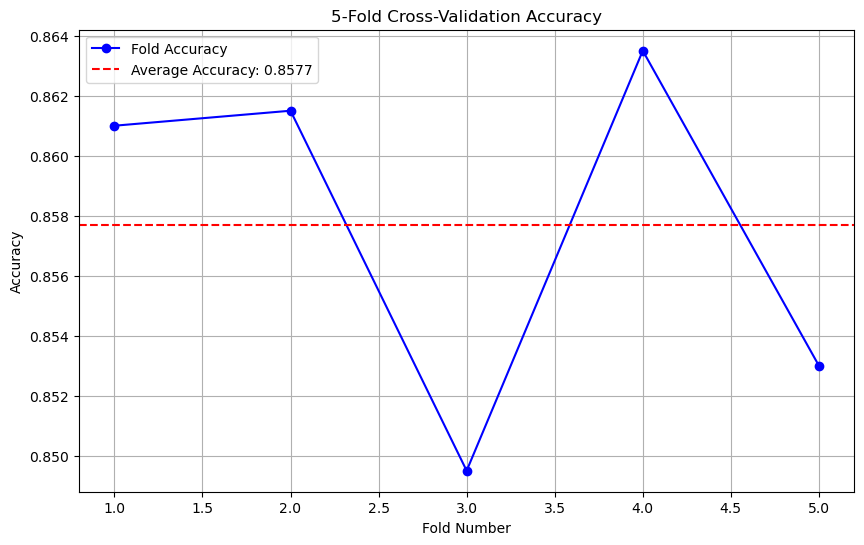

In [104]:
# Plot the accuracy scores for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(mean_accuracy_s, color='r', linestyle='--', label=f'Average Accuracy: {mean_accuracy_s:.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 3.Titanic Survival Prediction

## Implementing with OUR XGBoost

In [106]:
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('dataset/Titanic/train.csv')
test = pd.read_csv('dataset/Titanic/test.csv')

# Concatenate training set and test set
X_full = pd.concat([train.drop('Survived', axis = 1), test], axis = 0)

# Clean X_full
X_full.drop('PassengerId', axis = 1, inplace=True)
X_full['Nulls'] = X_full.Cabin.isnull().astype('int') + X_full.Age.isnull().astype('int')

# Divide the cabin category by simply extracting the first letter
X_full['Cabin_mapped'] = X_full['Cabin'].astype(str).str[0]
cabin_dict = {k:i for i, k in enumerate(X_full.Cabin_mapped.unique())} 

# Transform 'Age' and 'Cabin'
X_full.loc[:, 'Cabin_mapped'] = X_full.loc[:, 'Cabin_mapped'].map(cabin_dict)
X_full.drop(['Age', 'Cabin'], inplace = True, axis = 1)

# Assume people with missing fare paid the average price
fare_mean = X_full[X_full.Pclass == 3].Fare.mean()
X_full['Fare'].fillna(fare_mean, inplace = True)
X_full['Embarked'].fillna('S', inplace = True)

# Fit and transform the categorical data
X_full.drop(['Name', 'Ticket'], axis = 1, inplace = True)
X_dummies = pd.get_dummies(X_full, columns = ['Sex', 'Nulls', 'Cabin_mapped', 'Embarked'], drop_first= True)

# Split and construct desired dataset
X = X_dummies[:len(train)]; new_X = X_dummies[len(train):]
y = train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
model = XGBoost(num_trees=5, max_depth=5, learning_rate=0.3)

# Trains the XGBoost model on the training data.
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
model.train(X_train, y_train, detailed=False)

# Generates predictions on the test data.
predictions = model.predict(X_test)

# Convert predictions to binary labels (0 or 1) using a threshold of 0.5
predictions = np.where(predictions >= 0.5, 1, 0)

# Calculate the accuracy of the model
accuracy = np.mean(predictions == y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8268156424581006


### K-Fold Cross Validation

In [109]:
from sklearn.model_selection import KFold
# Define 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store accuracy for each fold
accuracy_scores = []
#Perform 5-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Create an XGBoost model with log loss as the evaluation metric
    model_x = XGBoost(num_trees=5, max_depth=5, learning_rate=0.3)
    model_x.train(X_train, y_train, detailed=False)
    # Generate predictions
    y_prob = model.predict(X_test)
    predictions = np.where(y_prob >= 0.5, 1, 0)
    
    # Calculate accuracy for this fold
    accuracy = np.mean(predictions == y_test)
    accuracy_scores.append(accuracy)
    print(f'Fold {fold} Accuracy: {accuracy:.8f}')

# Calculate the average accuracy across all folds
mean_accuracy_s = np.mean(accuracy_scores)

Fold 1 Accuracy: 0.78536313
Fold 2 Accuracy: 0.79528090
Fold 3 Accuracy: 0.84022472
Fold 4 Accuracy: 0.79528090
Fold 5 Accuracy: 0.81775281


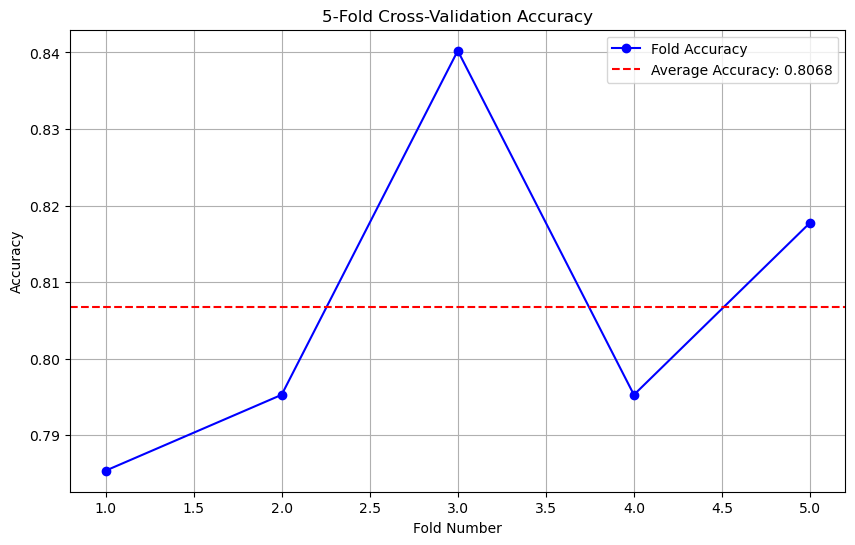

In [110]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(mean_accuracy_s, color='r', linestyle='--', label=f'Average Accuracy: {mean_accuracy_s:.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Implementing with imported XGBoost

In [112]:
model = xgb.XGBClassifier(n_estimators=5, max_depth=5, eval_metric='logloss')
model.fit(X_train, y_train)
params = model.get_params()
print(params)
n_estimators = params['n_estimators']
max_depth = params['max_depth']
learning_rate = params['learning_rate']

print("Number of estimators:", n_estimators)
print("Max depth:", max_depth)
print("Learning rate:", learning_rate)

# Retrieve the trained booster (underlying model) from XGBoost
booster = model.get_booster()

# Iterate over each tree in the model and print its structure
for i, tree in enumerate(booster.get_dump()):
    print(f"Tree {i + 1} structure:\n{tree}\n")

# Make predictions on the test data
y_pred_s = model.predict(X_test)

# Compute and print the accuracy score
accuracy_s = accuracy_score(y_test, y_pred_s)
print("Model Accuracy:", accuracy_s)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 5, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Number of estimators: 5
Max depth: 5
Learning rate: None
Tree 1 structure:
0:[f4<1] yes=1,no=2,missin

### K-Fold Cross Validation

In [113]:
from sklearn.model_selection import KFold

# Define 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store accuracy for each fold
accuracy_scores = []

# Perform 5-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data into train and test sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create an XGBoost model with log loss as the evaluation metric
    model = xgb.XGBClassifier(n_estimators=5, max_depth=5, eval_metric='logloss')
    
    # Fits the XGBoost model to the training data.
    model.fit(X_train, y_train)
    
    # Generate predictions
    predictions = model.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    print(f'Fold {fold} Accuracy: {accuracy:.4f}')

# Calculate the average accuracy across all folds
mean_accuracy_s = np.mean(accuracy_scores)

Fold 1 Accuracy: 0.8156
Fold 2 Accuracy: 0.7865
Fold 3 Accuracy: 0.8596
Fold 4 Accuracy: 0.7921
Fold 5 Accuracy: 0.8202


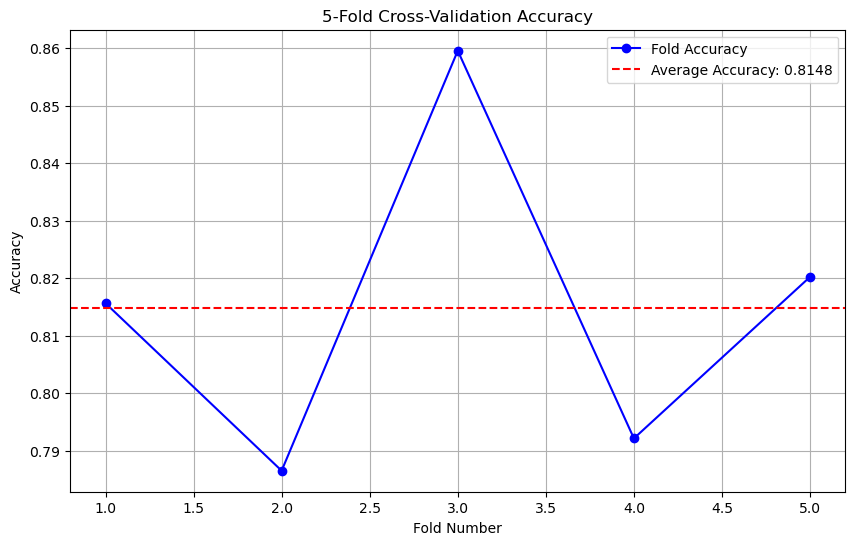

In [114]:
# Plot the accuracy scores for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(mean_accuracy_s, color='r', linestyle='--', label=f'Average Accuracy: {mean_accuracy_s:.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()